In [144]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int
from spec_extract import Scale_spectra
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [12]:
galDB = pd.read_pickle('../dataframes/galaxy_database.pkl')
lzDB = galDB.query('z_grism < 1.5')
mzDB = galDB.query('1.5 < z_grism < 1.8')
hzDB = galDB.query('1.8 < z_grism < 2.1')
uhzDB = galDB.query('2.1 < z_grism')

lwa = np.load('../data/light_weight_scaling_3.npy')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [81]:
ult = np.append(0,10**(np.array(tau)[1:]-9))

In [27]:
def Smooth(f,x):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    fx = ksmooth.locpoly(x,f,bandwidth = H)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

In [3]:
def Stack(wv,flgrid,errgrid,contam):
#     for i in range(len(flgrid)):
#         flgrid[i][contam[i]**2 / (errgrid[i]**2 - contam[i]**2) > 1] = 0
#         errgrid[i][contam[i]**2 / (errgrid[i]**2 - contam[i]**2) > 1] = 1E5
    
    
    flgrid = np.transpose(flgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    
    return stack, err

In [143]:
# grp = multifit.GroupFLT(grism_files = glob(dpath+'Grism_fields/GS3/*GrismFLT.fits'))

beams = grp.get_beams(42113, size=20)
mb = multifit.MultiBeam(beams, fcontam=1.0)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3458: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/

In [144]:
g102 = mb.oned_spectrum()['G102']
g141 = mb.oned_spectrum()['G141']

Bwv = g102['wave']
Bflx = g102['flux'] / g102['flat']
Berr = g102['err'] / g102['flat']
Bflt = g102['flat']

Rwv = g141['wave']
Rflx = g141['flux'] / g141['flat']
Rerr = g141['err'] / g141['flat']
Rflt = g141['flat']

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we lo

<ErrorbarContainer object of 3 artists>

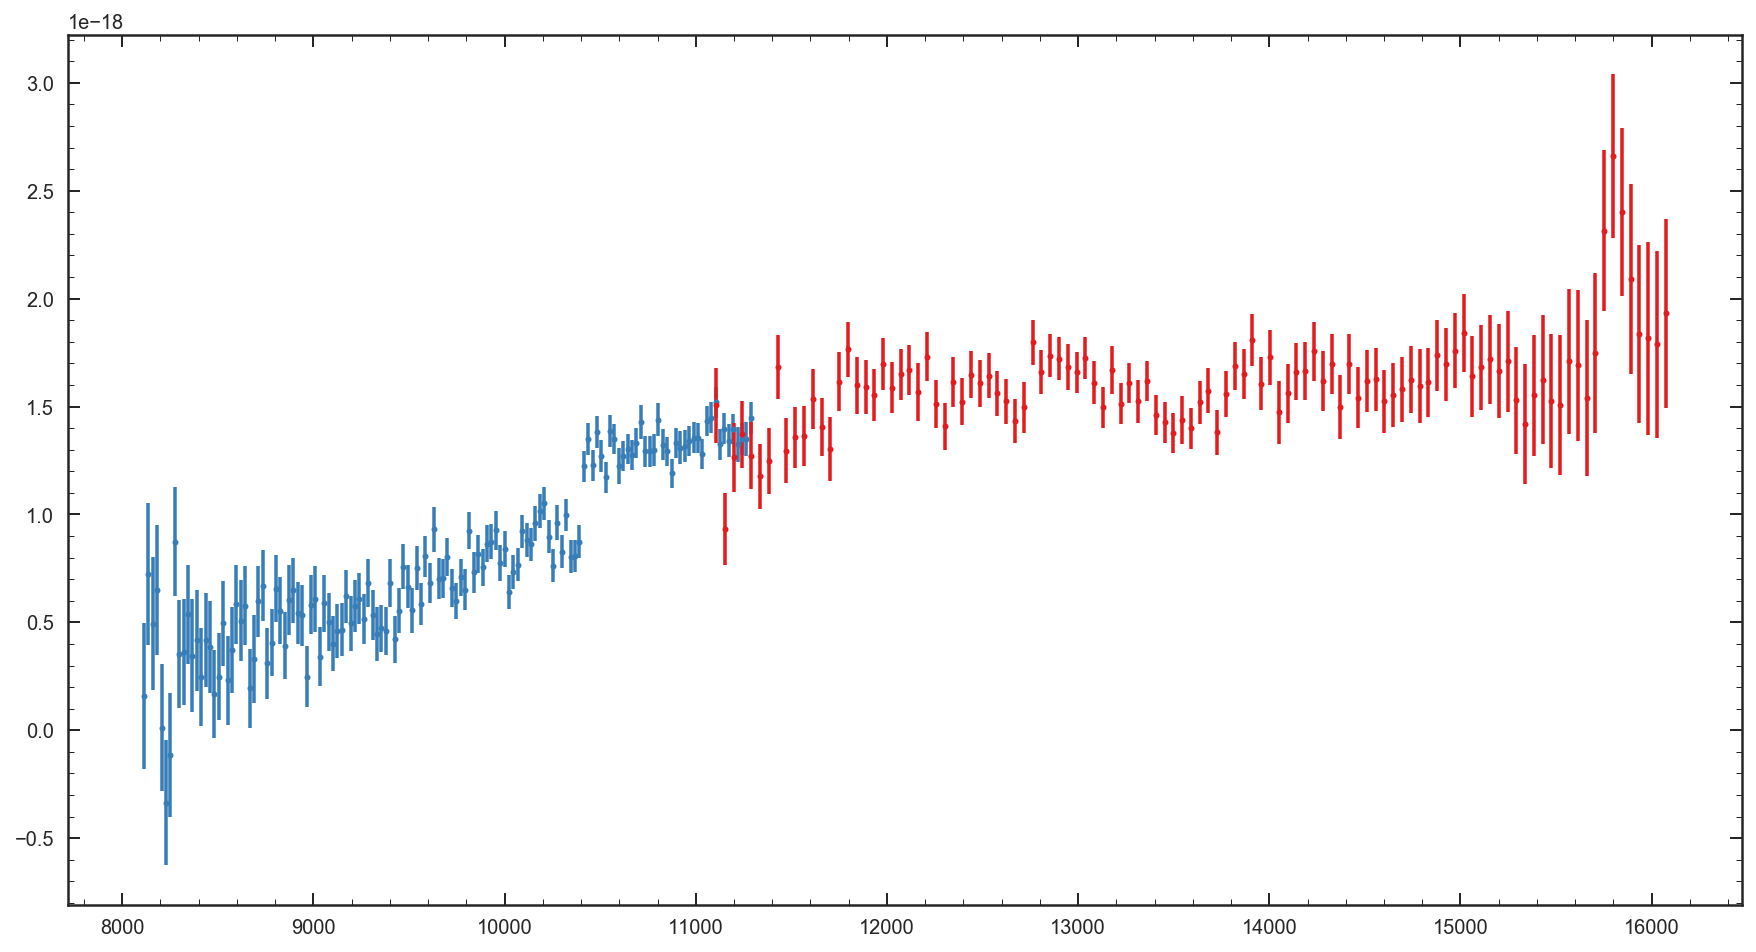

In [146]:
plt.figure(figsize=[15,8])

IDB = [U for U in range(len(Bwv)) if 8100 < Bwv[U] < 11300]
IDR = [U for U in range(len(Rwv)) if 11100 < Rwv[U] < 16100]

plt.errorbar(Bwv[IDB],Bflx[IDB],Berr[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR],Rflx[IDR],Rerr[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

# plt.figure(figsize=[15,8])

# plt.errorbar(sp.Bwv,sp.Bflx,sp.Berr,
#             linestyle='None', marker='o', markersize=3, color='#377eb8')
# plt.errorbar(sp.Rwv,sp.Rflx,sp.Rerr,
#             linestyle='None', marker='o', markersize=3, color='#e41a1c')


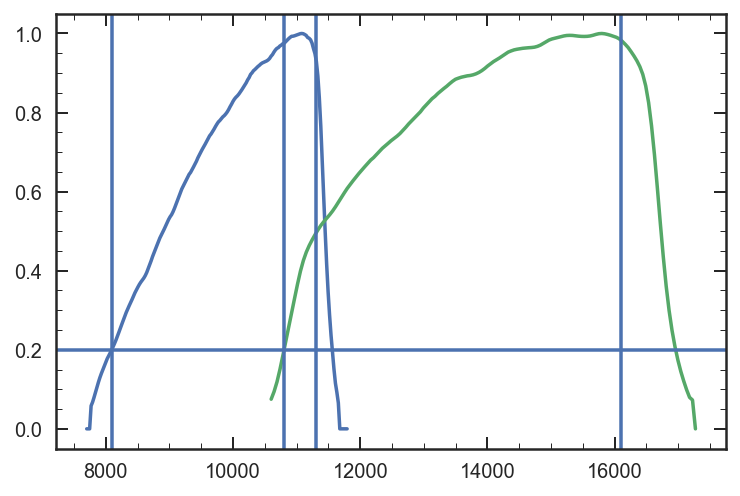

In [145]:
plt.plot(Bwv,Bflt / max(Bflt))
plt.plot(Rwv,Rflt / max(Rflt))
plt.axhline(0.2)
plt.axvline(8100)
plt.axvline(11300)
plt.axvline(10800)
plt.axvline(16100)

In [65]:
def L_nu_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    lam_0 = lam / (1 + z) # restframe wavelenth in angstrom
    dust = 10**(-0.4*Av)
    return ((lam_0**2)/(c * m_star)) * l_aa * dust * 3.839E33

def F_nu_per_M(l_aa, lam, z, Av, m_star):
    conv = 3.086E24 # conversion of Mpc to cm
    D_l = cosmo.luminosity_distance(z).value # in Mpc
    return (1 + z) * L_nu_per_M(l_aa, lam, z, Av, m_star)  / (4 * np.pi * (D_l*conv)**2)

def F_lam_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    return (c / lam**2) * F_nu_per_M(l_aa, lam, z, Av, m_star)

def Get_mass(gwv, gfl, ger, Z, t, z, Av):
    sp = fsps.StellarPopulation(imf_type=1, tpagb_norm_type=0, zcontinuous=1, logzsol=np.log10(Z / 0.019), sfh=0)
    wave,flux=np.array(sp.get_spectrum(tage=t,peraa=True))
    
    fl_m = F_lam_per_M(flux, wave * (1 + z), z, Av, sp.stellar_mass)
    
    IDX = [U for U in range(len(gwv)) if 8000 < gwv[U] < 11300]
    return np.log10(Scale_model(gfl[IDX],ger[IDX],interp1d(wv,fl_m)(gwv[IDX])))

In [168]:
data_path = '../data/'
model_path = hpath + 'fsps_models_for_fit/fsps_spec/'
chi_path = '../chidat/'
spec_path = '../spec_files/'
beam_path = '../beams/'
template_path = '../templates/'
out_path = '../data/posteriors/'
phot_path = '../phot/'

"""
FUNCTIONS:
-Calzetti_low
-Calzetti_hi
-Calzetti

CLASSES:
-Gen_spec
--Sim_spec_indv
--Sim_spec_mult
--Sim_spec_mult_point
--Sim_spec
--Sim_phot_mult
--Sim_phot
--Sim_all
"""


def Calzetti_low(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*Av/Rv)
    return cal

def Calzetti_hi(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-1.857 +1.04/(lam)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

def Calzetti(Av,lam):
    dust = Calzetti_low(Av,lam)
    dust2 = Calzetti_hi(Av,lam)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    
    return dust

class Gen_spec(object):
    def __init__(self, field, galaxy_id, specz, g102_beam, g141_beam,
                 g102_lims = [7900, 11300], g141_lims = [11100, 16000],
                 filter_102 = 201, filter_141 = 203, tmp_err = False, 
                 phot_tmp_err = False, errterm = 0):
        self.field = field
        self.galaxy_id = galaxy_id
        self.specz = specz
        self.c = 3E18          # speed of light angstrom s^-1
        self.g102_lims = g102_lims
        self.g141_lims = g141_lims
        
        """
        B - prefix refers to g102
        R - prefix refers to g141
        P - prefix refers to photometry
        
        field - GND/GSD/UDS
        galaxy_id - ID number from 3D-HST
        specz - z_grism
        g102_lims - window for g102
        g141_lims - window for g141
        tmp_err - (flag) whether or not we apply a template error function (not available)
        """
        self.Bwv, self.Bflx, self.Berr, self.Bflt = np.load('../spec_files/{0}_{1}_g102.npy'.format(field, galaxy_id))
        self.Rwv, self.Rflx, self.Rerr, self.Rflt = np.load('../spec_files/{0}_{1}_g141.npy'.format(field, galaxy_id))
        self.Bmask = np.load('../spec_files/spec_mask/{0}_{1}_g102_mask.npy'.format(field, galaxy_id))
        self.Rmask = np.load('../spec_files/spec_mask/{0}_{1}_g141_mask.npy'.format(field, galaxy_id))
        
        self.Bwv = self.Bwv[self.Bmask]
        self.Bflt = self.Bflt[self.Bmask]
        self.Bflx = self.Bflx[self.Bmask]
        self.Berr = self.Berr[self.Bmask] 
        
        self.Rwv = self.Rwv[self.Rmask]
        self.Rflt = self.Rflt[self.Rmask]
        self.Rflx = self.Rflx[self.Rmask]
        self.Rerr = self.Rerr[self.Rmask] 
        
        self.Pwv, self.Pflx, self.Perr, self.Pnum = np.load('../phot/{0}_{1}_phot.npy'.format(field, galaxy_id))
        self.Pwv_rf = self.Pwv / (1 + self.specz)
                
        self.IDB = [U for U in range(len(self.Bwv)) if g102_lims[0] <= self.Bwv[U] <= g102_lims[-1] and self.Bflx[U]**2 > 0]
        self.IDR = [U for U in range(len(self.Rwv)) if g141_lims[0] <= self.Rwv[U] <= g141_lims[-1] and self.Rflx[U]**2 > 0]

        self.Bwv = self.Bwv[self.IDB]
        self.Bwv_rf = self.Bwv / (1 + specz)
        self.Bflt = self.Bflt[self.IDB]
        self.Bflx = self.Bflx[self.IDB] #* Bscale
        self.Berr = self.Berr[self.IDB] #* Bscale
        
        self.Rwv = self.Rwv[self.IDR]
        self.Rwv_rf = self.Rwv / (1 + specz)
        self.Rflt = self.Rflt[self.IDR]
        self.Rflx = self.Rflx[self.IDR] #* Rscale
        self.Rerr = self.Rerr[self.IDR] #* Rscale

        self.model_photDF = pd.read_pickle('../phot/model_photometry_list.pkl')
        
        self.IDP = []
        for i in range(len(self.Pnum)):
            for ii in range(len(self.model_photDF)):
                if self.Pnum[i] == self.model_photDF.tmp_num[self.model_photDF.index[ii]]:
                    self.IDP.append(ii)
        
        if phot_tmp_err:
            ewv, tmp= np.loadtxt(hpath + 'eazy-photoz/templates/TEMPLATE_ERROR.eazy_v1.0').T
            iphterr = interp1d(ewv,tmp)(self.Pwv_rf)
            self.Perr_o = self.Perr
            self.Perr = np.sqrt(self.Perr**2 + (iphterr * self.Pflx)**2+ (errterm * self.Pflx)**2)
            
#         if tmp_err:
#             WV,TEF = np.load(data_path + 'template_error_function.npy')
#             iTEF = interp1d(WV,TEF)(self.gal_wv_rf)
#             self.gal_er = np.sqrt(self.gal_er**2 + (iTEF*self.fl)**2)

        self.Bbeam = model.BeamCutout(fits_file = g102_beam)
        self.Rbeam = model.BeamCutout(fits_file = g141_beam)

        #self.Bpoint_beam = model.BeamCutout(fits_file = '../beams/point_41086.g102.A.fits')
        #self.Rpoint_beam = model.BeamCutout(fits_file = '../beams/point_41086.g141.A.fits')
        
        ### Define precalculated terms for photometry
        self.sens_wv, self.trans = np.load('../templates/master_tmp.npy')
        self.b = np.load('../templates/bottom_precalc.npy')
        self.dnu = np.load('../templates/dnu_precalc.npy')
        self.adj = np.load('../templates/adj_precalc.npy')
        self.mdleffwv = np.load('../templates/effwv_precalc.npy') 
    
    def Sim_spec_indv(self, BEAM, model_wave, model_flux):
        ### creates a model using an individual beam
        BEAM.beam.compute_model(spectrum_1d=[model_wave, model_flux])
        w, f, e = BEAM.beam.optimal_extract(BEAM.beam.model, bin=0)
        return w, f
        
    def Sim_spec_mult(self, model_wave, model_flux):
        ### creates a model for g102 and g141 using individual beams
        return self.Sim_spec_indv(self.Bbeam, model_wave, model_flux), \
                self.Sim_spec_indv(self.Rbeam, model_wave, model_flux)

    def Sim_spec_mult_point(self, model_wave, model_flux):
        ### creates a model for g102 and g141 using individual beams
        return self.Sim_spec_indv(self.Bpoint_beam, model_wave, model_flux), \
                self.Sim_spec_indv(self.Rpoint_beam, model_wave, model_flux)
    
    def Sim_spec(self, metal, age, tau, model_redshift = 0, Av = 0, multi_component = False,
                point_scale=1):
        if model_redshift ==0:
            model_redshift = self.specz

        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(
            metal, age, tau))

        [Bmw, Bmf], [Rmw, Rmf] = self.Sim_spec_mult(model_wave * (1 + model_redshift), 
                                                                        model_flux * Calzetti(Av,model_wave))
        iBmf = interp1d(Bmw,Bmf)(self.Bwv)       
        iRmf = interp1d(Rmw,Rmf)(self.Rwv)     
        
        self.Bmfl = iBmf / self.Bflt
        self.Rmfl = iRmf / self.Rflt
            
        self.Bmfl *= Scale_model(self.Bflx, self.Berr, self.Bmfl)
        self.Rmfl *= Scale_model(self.Rflx, self.Rerr, self.Rmfl)
        
        if multi_component:
            [Bpmw, Bpmf], [Rpmw, Rpmf] = self.Sim_spec_mult_point(model_wave * (1 + model_redshift), 
                                                                            model_flux * Calzetti(Av,model_wave))
            iBpmf = interp1d(Bpmw,Bpmf)(self.Bwv)       
            iRpmf = interp1d(Rpmw,Rpmf)(self.Rwv)     

            self.Bpmfl = iBpmf / self.Bflt
            self.Rpmfl = iRpmf / self.Rflt

            self.Bpmfl *= Scale_model(self.Bflx, self.Berr, self.Bpmfl)
            self.Rpmfl *= Scale_model(self.Rflx, self.Rerr, self.Rpmfl)
            
            self.Bpmfl *= point_scale
            self.Rpmfl *= point_scale
            
            self.BMCmfl = self.Bmfl + self.Bpmfl
            self.RMCmfl = self.Rmfl + self.Rpmfl
            
            self.BMCmfl *= Scale_model(self.Bflx, self.Berr, self.BMCmfl)
            self.RMCmfl *= Scale_model(self.Rflx, self.Rerr, self.RMCmfl)
       
    def Sim_phot_mult(self, model_wave, model_flux):
        
        imfl =interp1d(self.c / model_wave, (self.c/(self.c / model_wave)**2) * model_flux)

        mphot = (np.trapz(imfl(self.c /(self.sens_wv[self.IDP])).reshape([len(self.IDP),len(self.sens_wv[0])]) \
                          * self.b[self.IDP],self.dnu[self.IDP])/np.trapz(self.b[self.IDP],
                                                                          self.dnu[self.IDP])) * self.adj[self.IDP]
        
        return np.array([self.mdleffwv[self.IDP],mphot])

    def Sim_phot(self, metal, age, tau, model_redshift = 0, Av = 0):
        if model_redshift ==0:
            model_redshift = self.specz

        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(
            metal, age, tau))
        
        self.Pmwv, self.Pmfl = self.Sim_phot_mult(model_wave * (1 + model_redshift), 
                                                  model_flux * Calzetti(Av,model_wave))
        self.PC =  Scale_model(self.Pflx, self.Perr, self.Pmfl)  
        self.Pmfl = self.Pmfl * self.PC
        
    def Sim_all(self, metal, age, tau, model_redshift = 0, Av = 0):
        self.Sim_spec(metal, age, tau, model_redshift, Av)
        self.Sim_phot(metal, age, tau, model_redshift, Av)
        
    def Scale_flux(self, bfZ, bft, bftau, bfz, bfd):
        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(bfZ, bft, bftau))
        
        US_model_flux = F_lam_per_M(model_flux * Calzetti(bfd,model_wave), model_wave * (1 + bfz), bfz, 0, 1)

        US_pwv, US_pfl = self.Sim_phot_mult(model_wave * (1 + bfz), US_model_flux)
        
        self.mass = Scale_model(self.Pflx, self.Perr, US_pfl)
        
        self.lmass = np.log10(self.mass)
        
        self.model_wave = model_wave
        self.S_model_flux = US_model_flux * self.mass
          
        Bmfl = interp1d(self.model_wave, self.S_model_flux)(self.Bwv_rf)
        Rmfl = interp1d(self.model_wave, self.S_model_flux)(self.Rwv_rf)
  
        self.Bscale = Scale_model(self.Bflx, self.Berr, Bmfl)
        self.Rscale = Scale_model(self.Rflx, self.Rerr, Rmfl)
        
        self.Bflx = self.Bflx / self.Bscale ; self.Berr = self.Berr / self.Bscale 
        self.Rflx = self.Rflx / self.Rscale ; self.Rerr = self.Rerr / self.Rscale 

# How to mass scale

### step 1: convert best fit model F$_\lambda$ / M$_\odot$ (unscaled model)

### step 2: generate photometry model using unscaled model

### step 3: use photometry and unscaled forward model to get mass of galaxy (mass scale) 

### step 4: scale model

### step 5: use scaled model to scale g102 and g141 data

In [169]:
idx = 0

sp1 = Gen_spec(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], g102_lims=[8500,11300])      

sp2 = Gen_spec(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], g102_lims=[8500,11300]) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3458: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.sc

In [170]:
bftau = np.array(tau)[np.round(ult,1) == np.round(galDB['taux'][idx],1)][0]

LWA = lwa[metal == galDB.Z[idx]].T[tau == bftau][0].T[0].T
mt = age[np.round(LWA,1) == galDB.t[idx]][0] 

if bftau == 0.0:
    mtau = int(0)
else:
    mtau = bftau

sp1.Scale_flux(galDB.Z[idx], mt, mtau, galDB.z_grism[idx], galDB.dx[idx])
sp1.Sim_all(galDB.Z[idx], mt, mtau, Av=galDB.dx[idx])

sp2.Bflx, sp2.Berr, sp2.Rflx, sp2.Rerr = Scale_spectra(sp2.Bwv,sp2.Bflx,sp2.Berr,sp2.Rwv,sp2.Rflx,sp2.Rerr,sp2.Pwv,sp2.Pflx) 

sp2.Sim_all(galDB.Z[idx], mt, mtau, Av=galDB.dx[idx])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


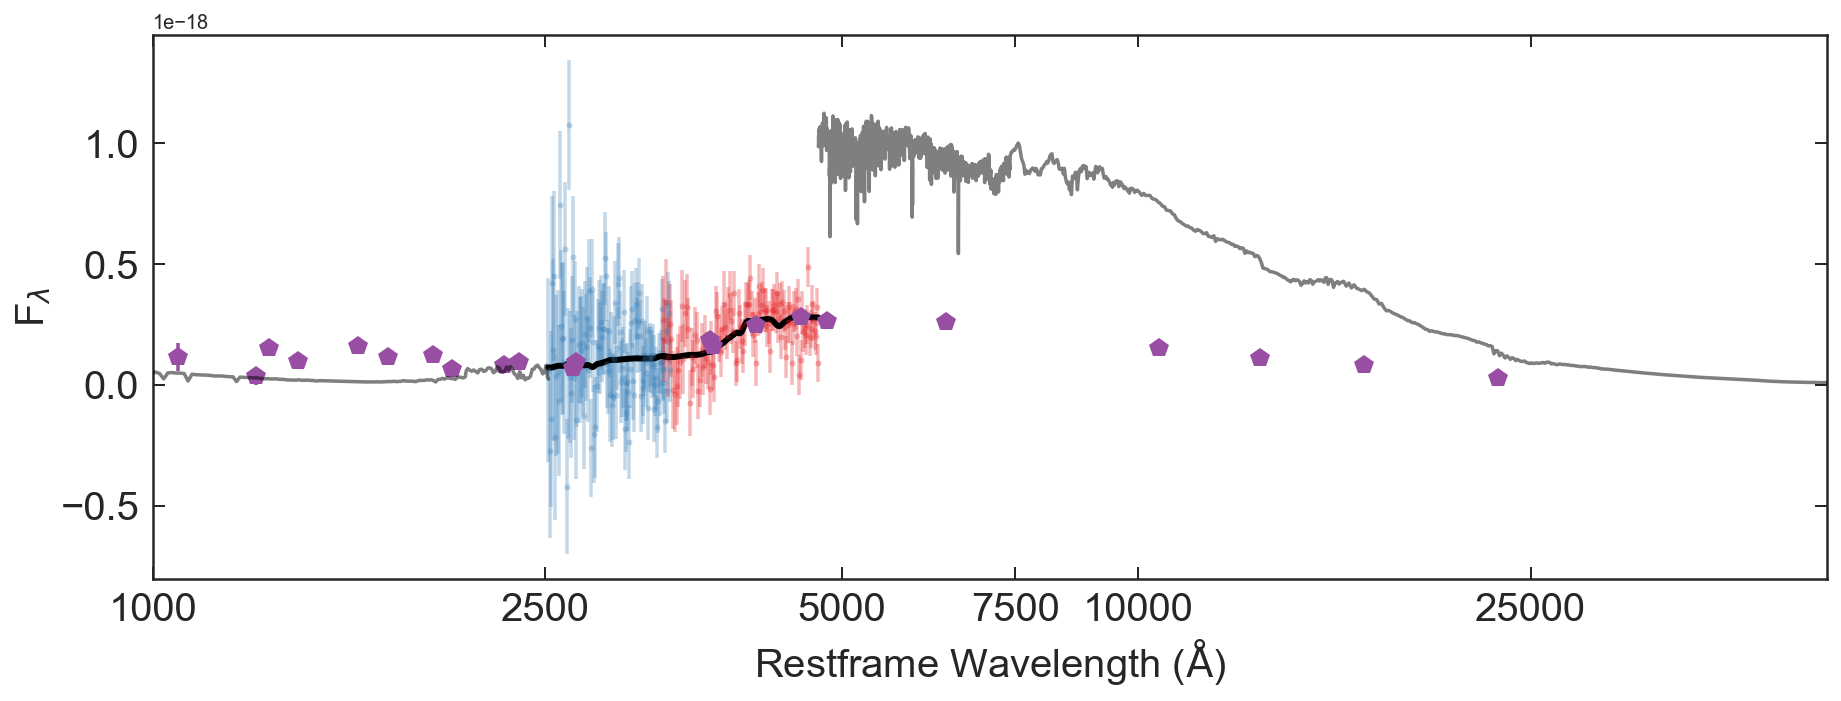

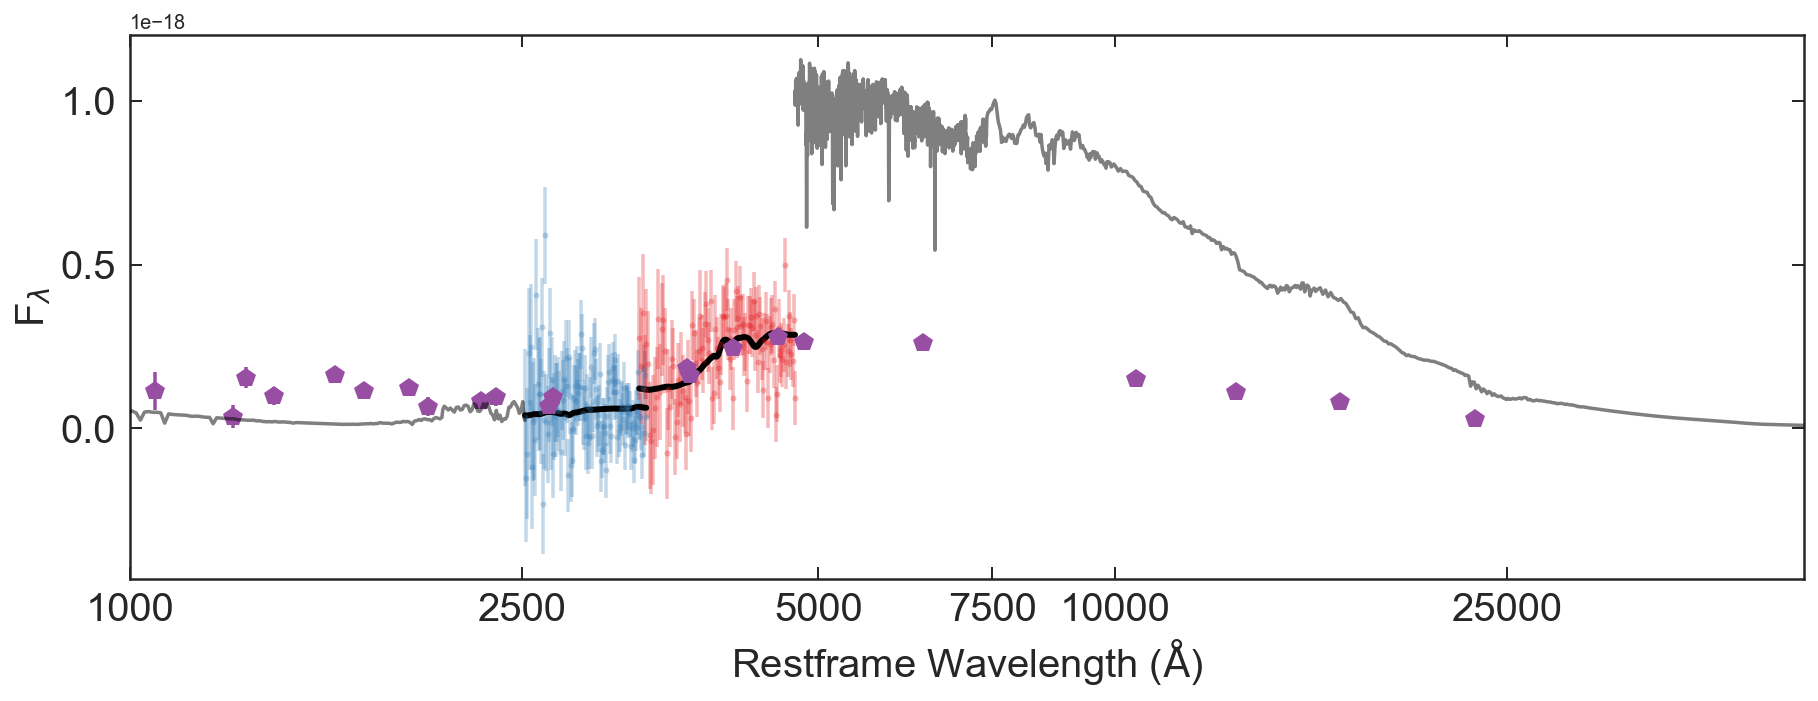

In [171]:
plt.figure(figsize=[15,5])
plt.errorbar(np.log10(sp1.Bwv_rf),sp1.Bflx,sp1.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(sp1.Rwv_rf),sp1.Rflx,sp1.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

plt.errorbar(np.log10(sp1.Pwv_rf),sp1.Pflx,sp1.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(sp1.Bwv_rf),sp1.Bmfl,'k',linewidth=3)
plt.plot(np.log10(sp1.Rwv_rf),sp1.Rmfl,'k',linewidth=3)


IDb = [U for U in range(len(sp1.model_wave)) if sp1.model_wave[U] < sp1.Bwv_rf[0]]
IDr = [U for U in range(len(sp1.model_wave)) if sp1.model_wave[U] > sp1.Rwv_rf[-1]]

plt.plot(np.log10(sp1.model_wave[IDb]),sp.S_model_flux[IDb],'k',ms=10,zorder =5,alpha=0.5)
plt.plot(np.log10(sp1.model_wave[IDr]),sp.S_model_flux[IDr],'k',ms=10,zorder =5,alpha=0.5)


plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)


plt.figure(figsize=[15,5])
plt.errorbar(np.log10(sp2.Bwv_rf),sp2.Bflx,sp2.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(sp2.Rwv_rf),sp2.Rflx,sp2.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

plt.errorbar(np.log10(sp2.Pwv_rf),sp2.Pflx,sp2.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(sp2.Bwv_rf),sp2.Bmfl,'k',linewidth=3)
plt.plot(np.log10(sp2.Rwv_rf),sp2.Rmfl,'k',linewidth=3)

IDb = [U for U in range(len(sp1.model_wave)) if sp1.model_wave[U] < sp1.Bwv_rf[0]]
IDr = [U for U in range(len(sp1.model_wave)) if sp1.model_wave[U] > sp1.Rwv_rf[-1]]

plt.plot(np.log10(sp1.model_wave[IDb]),sp.S_model_flux[IDb],'k',ms=10,zorder =5,alpha=0.5)
plt.plot(np.log10(sp1.model_wave[IDr]),sp.S_model_flux[IDr],'k',ms=10,zorder =5,alpha=0.5)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

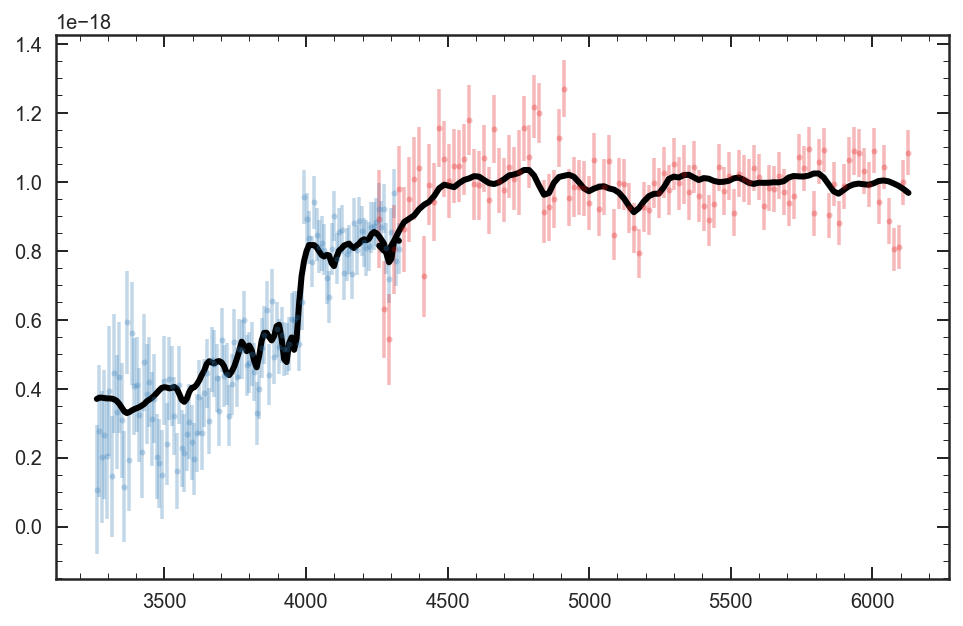

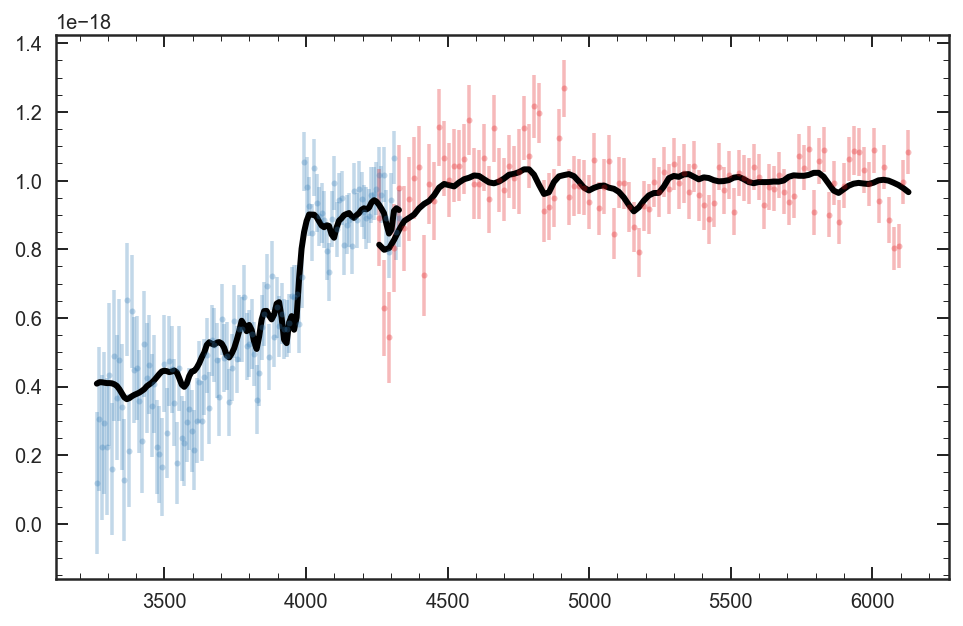

In [148]:
plt.figure(figsize=[8,5])
plt.errorbar(sp1.Bwv_rf,sp1.Bflx,sp1.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(sp1.Rwv_rf,sp1.Rflx,sp1.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)
plt.plot(sp1.Bwv_rf,sp1.Bmfl,'k',linewidth=3)
plt.plot(sp1.Rwv_rf,sp1.Rmfl,'k',linewidth=3)

plt.figure(figsize=[8,5])
plt.errorbar(sp2.Bwv_rf,sp2.Bflx,sp2.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(sp2.Rwv_rf,sp2.Rflx,sp2.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)
plt.plot(sp2.Bwv_rf,sp2.Bmfl,'k',linewidth=3)
plt.plot(sp2.Rwv_rf,sp2.Rmfl,'k',linewidth=3)


In [61]:
sp = fsps.StellarPopulation(imf_type=1, tpagb_norm_type=0, zcontinuous=1, logzsol=np.log10(0.019 / 0.019), sfh=0)
sp2 = fsps.StellarPopulation(imf_type=0, tpagb_norm_type=0, zcontinuous=1, logzsol=np.log10(0.019 / 0.019), sfh=0)


In [62]:
wave,flux=sp.get_spectrum(tage=0.5,peraa=True)
wave2,flux2=sp2.get_spectrum(tage=0.5,peraa=True)

In [19]:
wv, fl = np.load('/Users/vestrada/fsps_models_for_fit/fsps_spec/m0.019_a2.2_dt0_spec.npy')

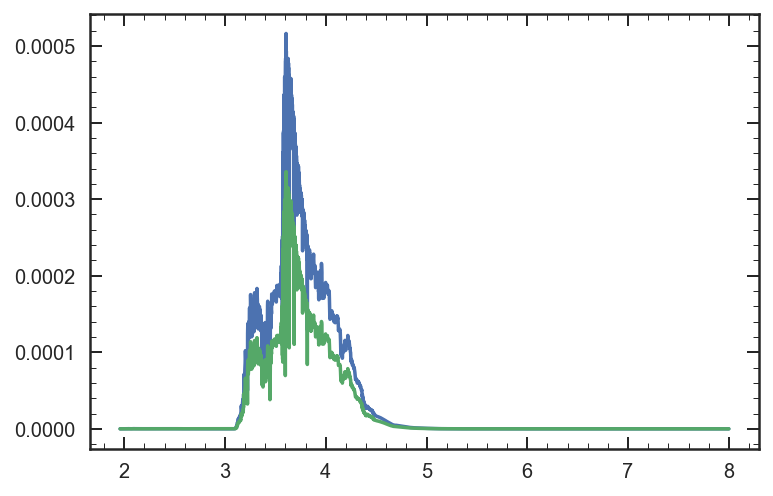

In [63]:
plt.plot(np.log10(wave),flux)
plt.plot(np.log10(wave2),flux2)


In [30]:
sp.stellar_mass, sp2.formed_mass

(0.7717970498867981, 1.0)

In [64]:
flux / flux2

array([1.56298483, 1.56298573, 1.56298586, ..., 1.55486629, 1.55486215,
       1.55486095])

In [151]:
Bflx2,Berr2,Rflx2,Rerr2 = Scale_spectra(Bwv, Bflx, Berr, Rwv, Rflx, Rerr,Pwv, Pflx)

(8000, 16200)

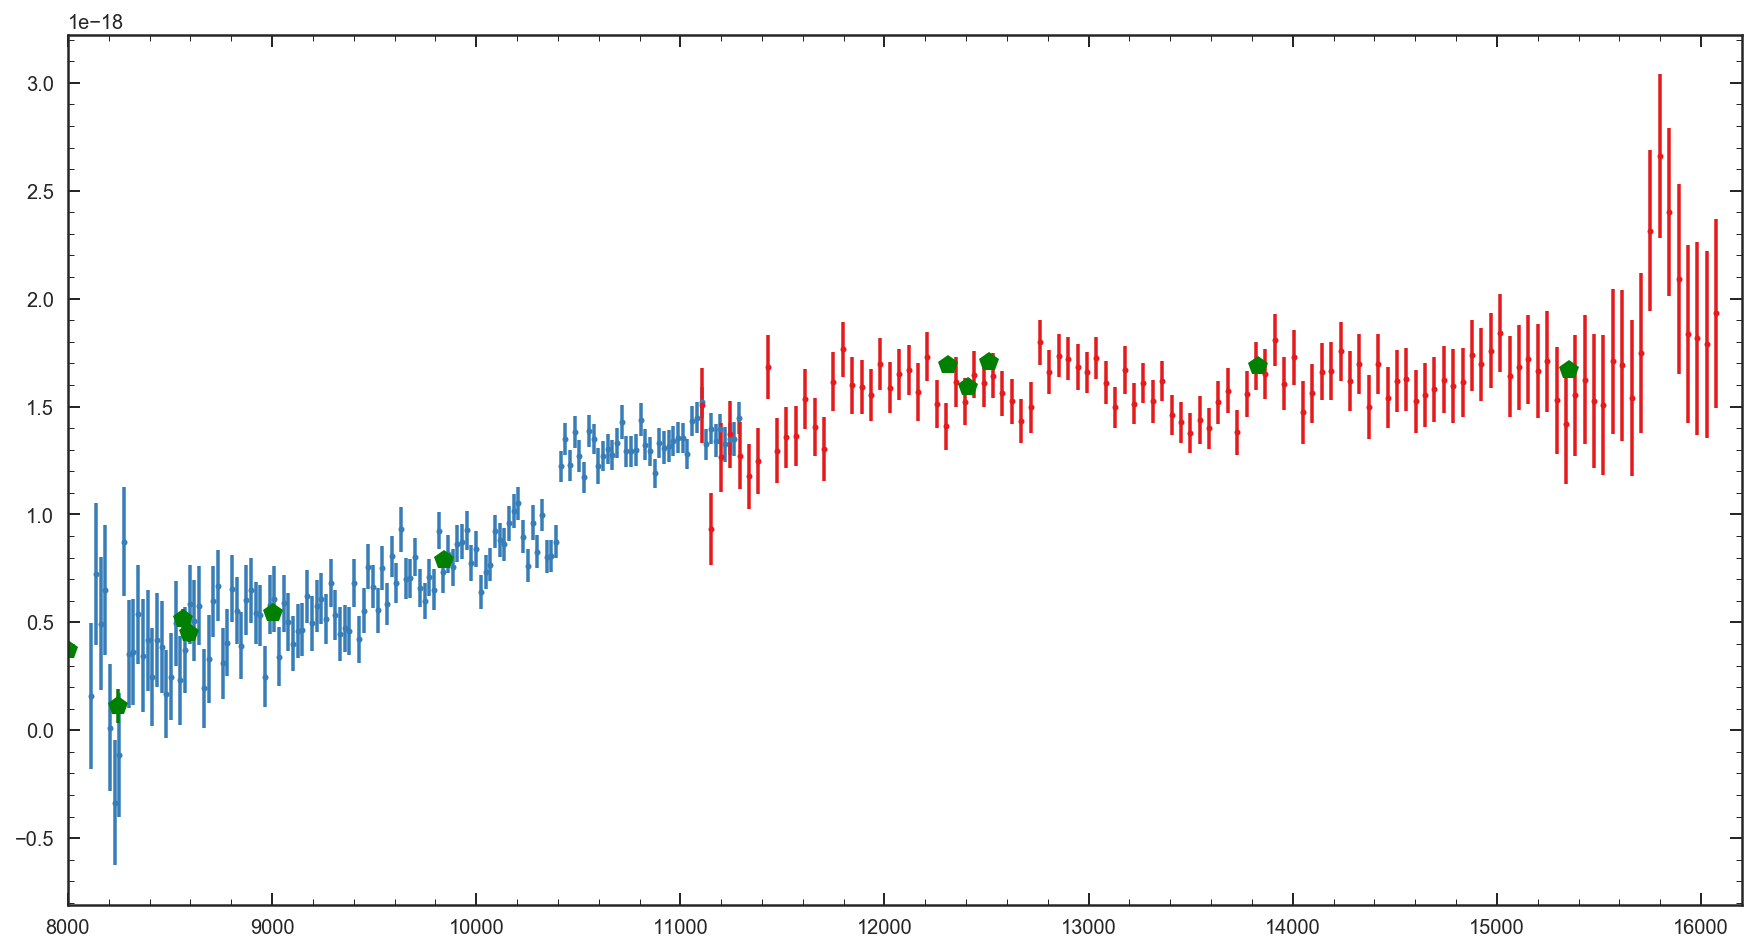

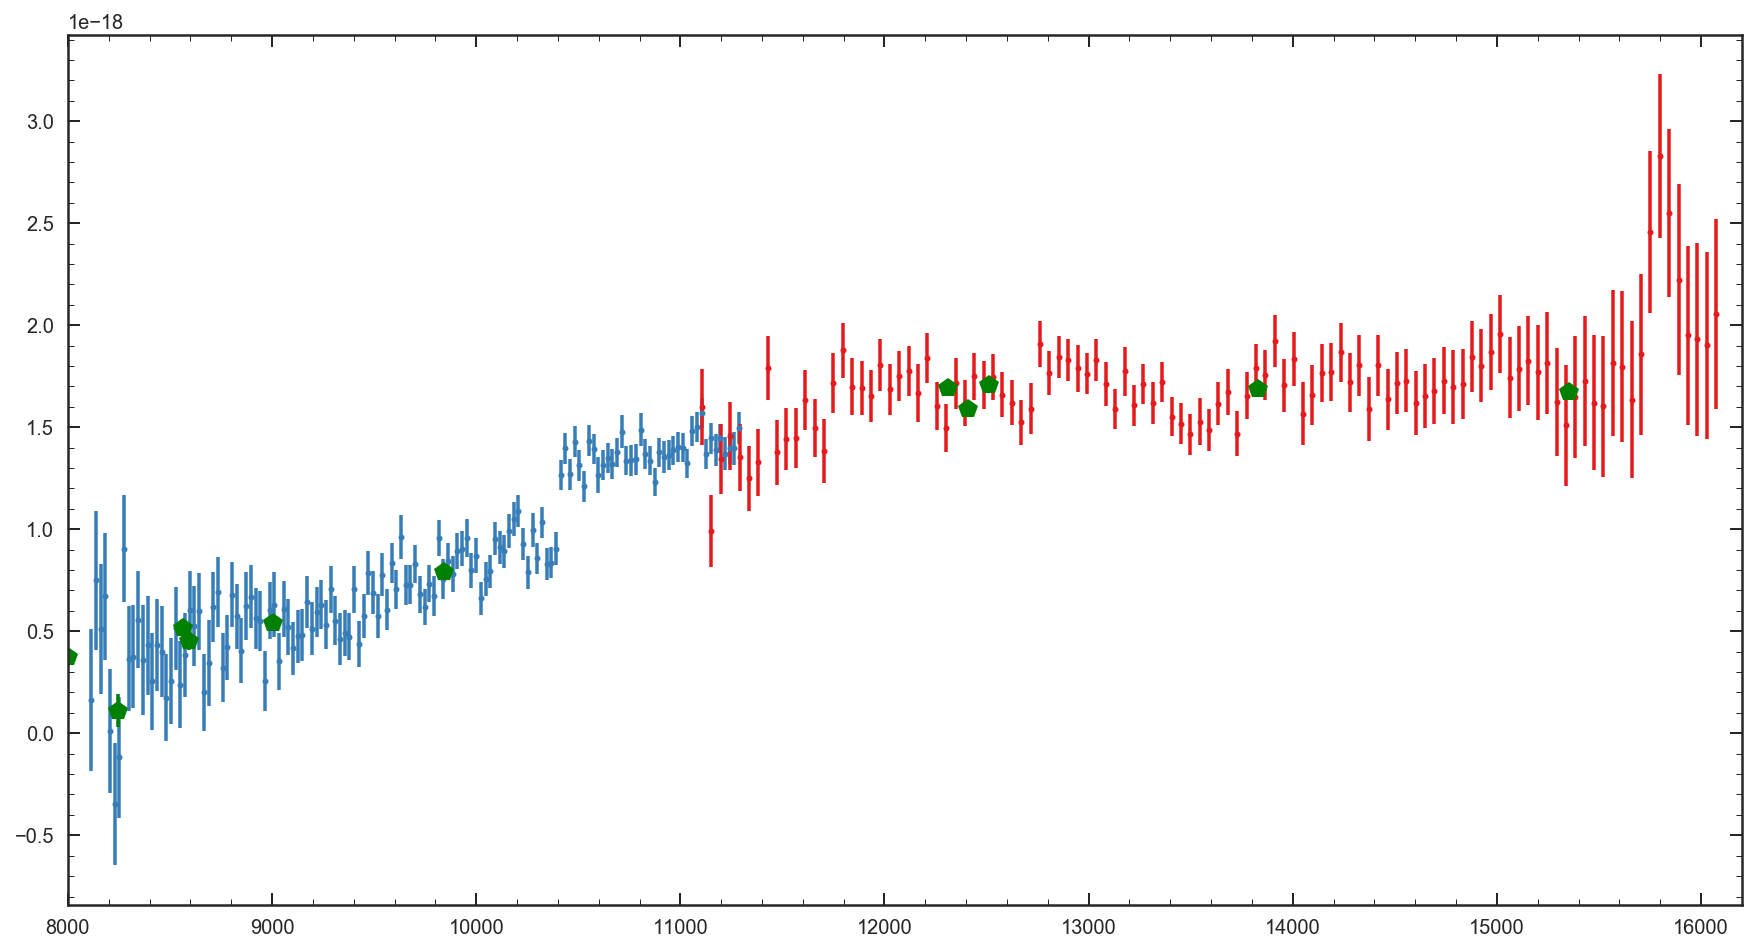

In [152]:
plt.figure(figsize=[15,8])
plt.errorbar(Bwv[IDB],Bflx[IDB],Berr[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR],Rflx[IDR],Rerr[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

plt.errorbar(Pwv, Pflx, Perr,
            linestyle='None', marker='p', markersize=10, color='G')
plt.xlim(8000,16200)

plt.figure(figsize=[15,8])

plt.errorbar(Bwv[IDB],Bflx2[IDB],Berr2[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR],Rflx2[IDR],Rerr2[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')


plt.errorbar(Pwv, Pflx, Perr,
            linestyle='None', marker='p', markersize=10, color='G')
plt.xlim(8000,16200)

In [109]:
bpas= []
rpas= []

pa = -1
for i in beams:
    if i.grism.filter == 'G102':
        if pa != i.get_dispersion_PA():
            pa = i.get_dispersion_PA()
            bpas.append(pa)
pa = -1            
for i in beams:
    if i.grism.filter == 'G141':
        if pa != i.get_dispersion_PA():
            pa = i.get_dispersion_PA()
            rpas.append(pa)      


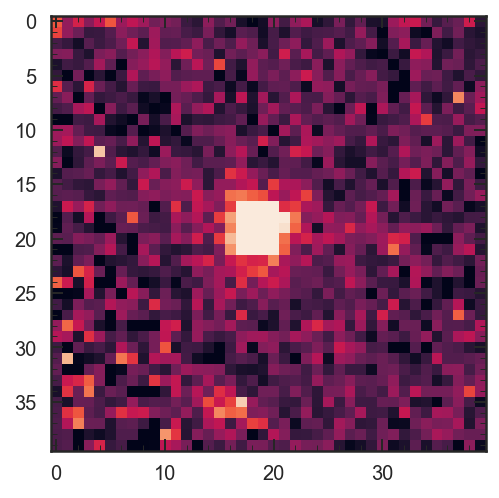

In [147]:
plt.imshow(np.arcsinh(beams[7].beam.direct), interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=1E-20)

In [121]:
co.beam.direct

array([[-7.8129737e-23, -2.8213046e-22,  4.6761392e-22, ...,
        -7.1239724e-22,  2.5623989e-22,  6.6993971e-22],
       [-4.6769607e-22,  1.1395424e-21, -7.0922897e-22, ...,
        -2.1425161e-21,  1.6511760e-21,  3.2535330e-22],
       [-1.0388221e-21,  7.9697862e-22,  2.5486705e-22, ...,
        -8.6408082e-22,  5.5929991e-22, -1.0440280e-21],
       ...,
       [-3.0401162e-22, -2.2999615e-22, -9.4847744e-23, ...,
        -8.1448962e-22, -6.0796836e-22, -8.5454523e-22],
       [ 1.1427353e-21, -2.2338824e-22, -3.8159386e-22, ...,
         1.2927779e-21, -8.1170763e-22,  9.4992838e-22],
       [ 6.2646643e-22, -1.4927792e-21, -7.6209608e-22, ...,
         3.1960173e-22,  5.6965527e-22, -7.9346104e-22]], dtype=float32)